In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy
import mplhep

import pandas
import boost_histogram as bh
import itertools
import mplhep
mplhep.set_style(mplhep.styles.CMS)

/var/folders/y7/dmw6mp6x7qz5hqc8qwpwwy1c0000gn/T/ipykernel_68978/1975773438.py:17: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [3]:
def flatten(arr):
    #return arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2]))
    return arr.reshape(-1, arr.shape[-1])
def cms_label(ax, x0=0.01, x1=0.15, x2=0.98, y=0.94):
    plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', transform=ax.transAxes)
    plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', transform=ax.transAxes)
    plt.figtext(x2, y,'Run 3 (14 TeV)',  wrap=False, horizontalalignment='right', transform=ax.transAxes)

# def cms_label_sample_label(x0=0.12, x1=0.23, x2=0.67, y=0.90):
#     plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left')
#     plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left')
#     plt.figtext(x2, y,'Run 3 (14 TeV), $\mathrm{t}\overline{\mathrm{t}}$ events',  wrap=False, horizontalalignment='left')

    
def sample_label(ax, additional_text="", x=0.01, y=0.87):
    plt.text(x, y, "$\mathrm{t}\overline{\mathrm{t}}$ events"+additional_text, ha="left", transform=ax.transAxes)
def apply_thresholds_f(ypred_raw_f, thresholds):
    msk = np.ones_like(ypred_raw_f)
    for i in range(len(thresholds)):
        msk[:, i+1] = ypred_raw_f[:, i+1]>thresholds[i]
    ypred_id_f = np.argmax(ypred_raw_f*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw_f, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, -1] - best_2[:, -2])
#     ypred_id_f[diff<0.05] = 0
    
    return ypred_id_f

def apply_thresholds(ypred_raw, thresholds):
    msk = np.ones_like(ypred_raw)
    for i in range(len(thresholds)):
        msk[:, :, i+1] = ypred_raw[:, :, i+1]>thresholds[i]
    ypred_id = np.argmax(ypred_raw*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, :, -1] - best_2[:, :, -2])
#     ypred_id[diff<0.05] = 0
    
    return ypred_id

In [5]:
import torch
path = '/Users/yoloz/downloads'
yvals = torch.load(f'{path}/post_processed_yvals.pt')
#Xs = torch.load(f'{path}/post_processed_Xs.pt')
backend = 'pyg'
first_index = 3
second_index = 3
Xs[first_index][second_index]
print("gen_px: " , yvals["gen_px"][first_index][second_index] , "\n",
      "gen_py: " , yvals["gen_py"][first_index][second_index] , "\n", 
      "gen_pz: " , yvals["gen_pz"][first_index][second_index] , "\n",
      "gen_energy: ", yvals["gen_energt"][first_index][second_index], "\n",
      "gen_cls_id: ", yvals["gen_cls_id"][first_index][second_index], "\n",
      "cand_px: " , yvals["cand_px"][first_index][second_index] , "\n",
      "cand_py: " , yvals["cand_py"][first_index][second_index] , "\n",
      "cand_pz" , yvals["cand_pz"][first_index][second_index], "\n",
      "cand_energy: ", yvals["cand_energt"][first_index][second_index], "\n",
      "cand_cls_id: ", yvals["cand_cls_id"][first_index][second_index], "\n",
     )

NameError: name 'Xs' is not defined

dict

Text(0, 1, 'Number of events / bin')

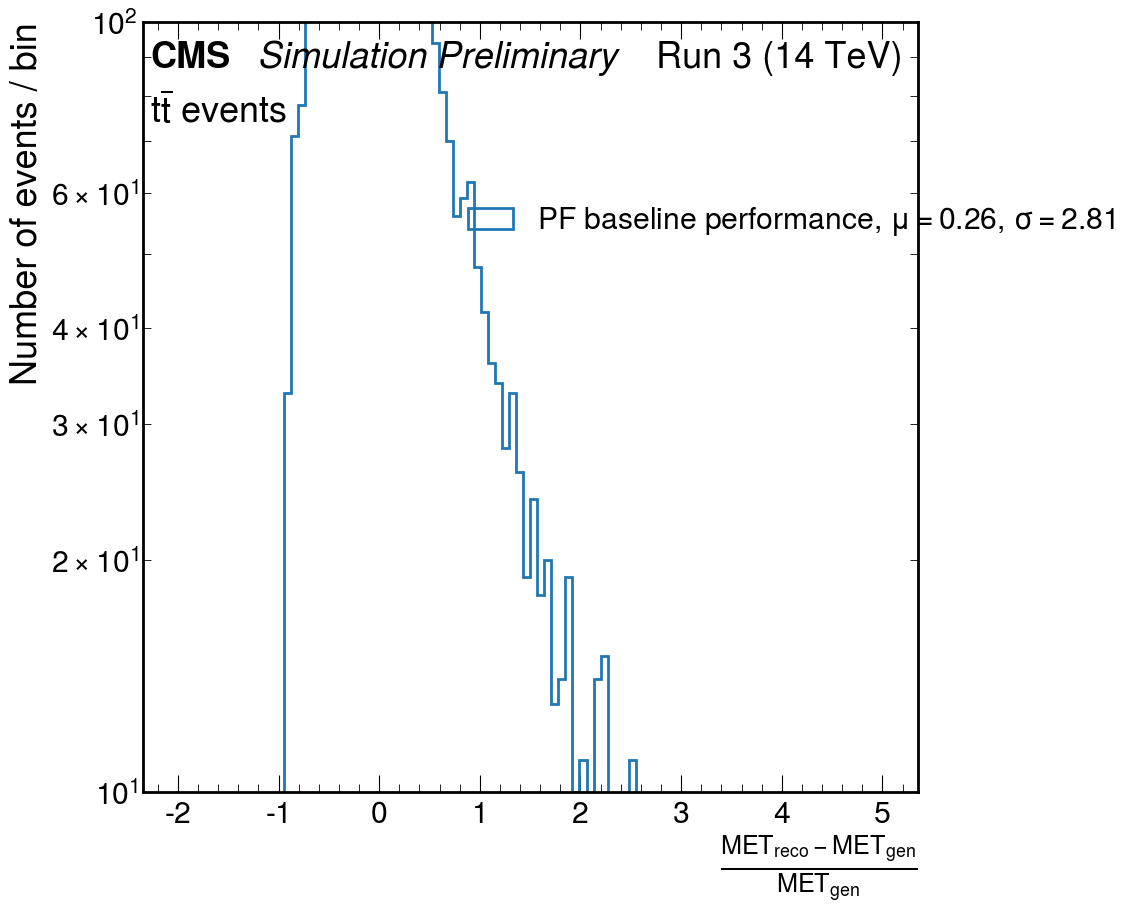

In [7]:
# plot MET
sum_px = np.sum(yvals["gen_px"], axis=1)
sum_py = np.sum(yvals["gen_py"], axis=1)
gen_met = np.sqrt(sum_px**2+sum_py**2)[:, 0]

sum_px = np.sum(yvals["cand_px"], axis=1)
sum_py = np.sum(yvals["cand_py"], axis=1)
cand_met = np.sqrt(sum_px**2+sum_py**2)[:, 0]

fig = plt.figure()
ax = plt.axes()
b = np.linspace(-2, 5, 101)
vals_a = (cand_met-gen_met)/gen_met
plt.hist(vals_a, bins=b, histtype="step", lw=2, label="PF baseline performance, $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(vals_a), np.std(vals_a)));
# plt.hist(vals_b, bins=b, histtype="step", lw=2, label="MLPF, $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(vals_b), np.std(vals_b)));
plt.yscale("log")
cms_label(ax)
sample_label(ax)
plt.ylim(10, 1e2)
plt.legend(loc=(0.4, 0.7))
plt.xlabel(r"$\frac{\mathrm{MET}_{\mathrm{reco}} - \mathrm{MET}_{\mathrm{gen}}}{\mathrm{MET}_{\mathrm{gen}}}$")
plt.ylabel("Number of events / bin")

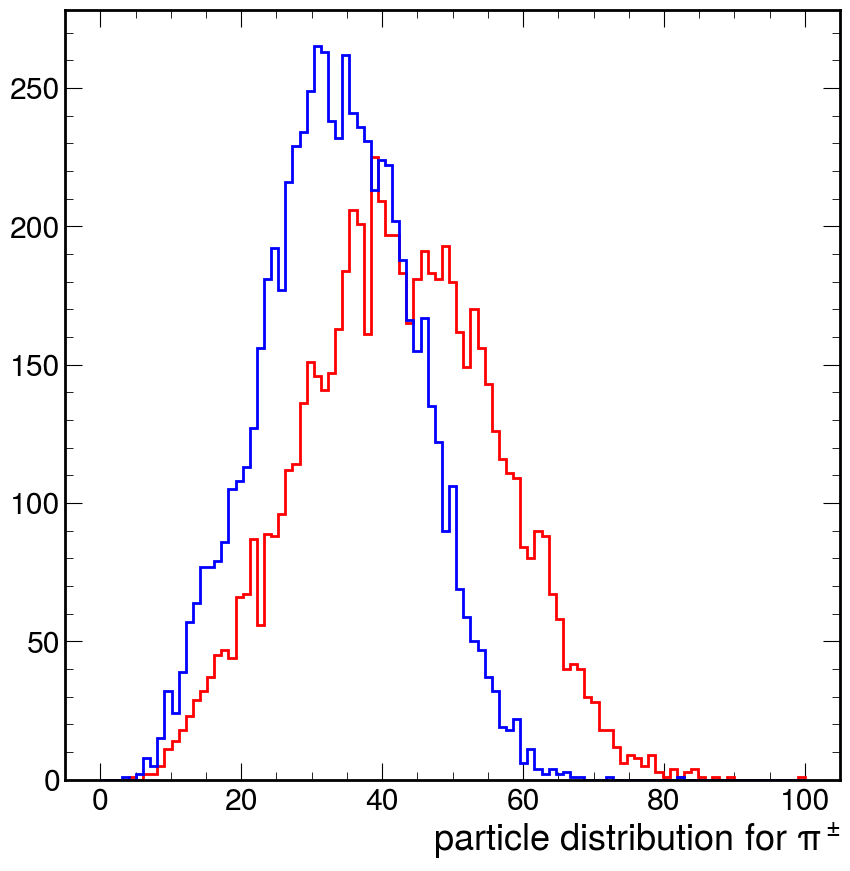

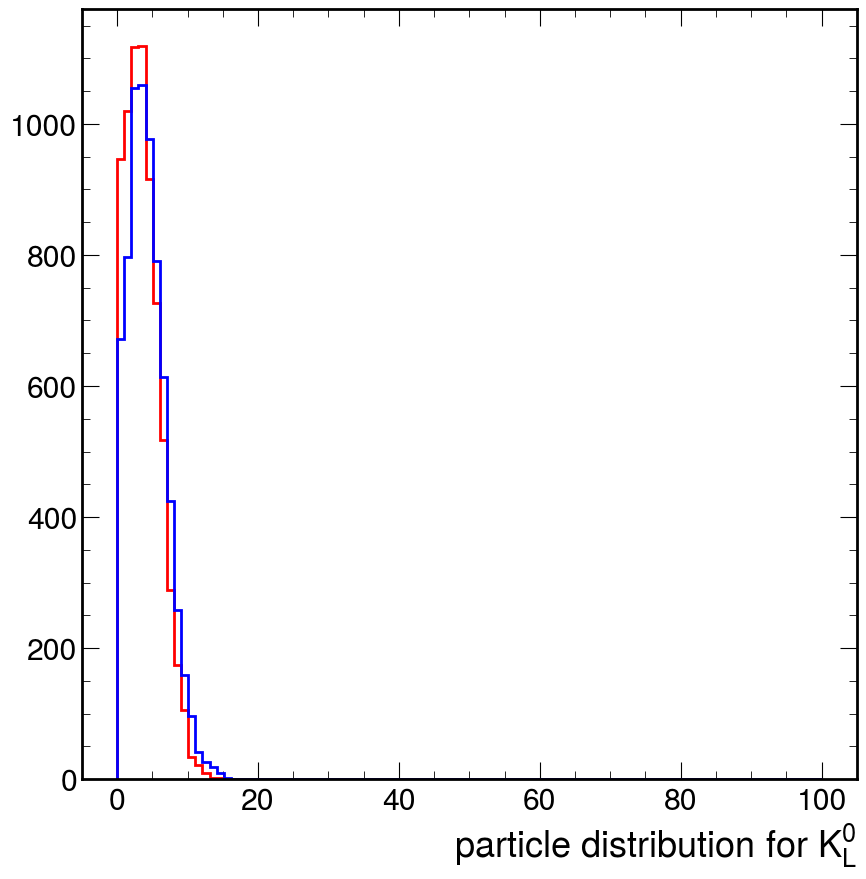

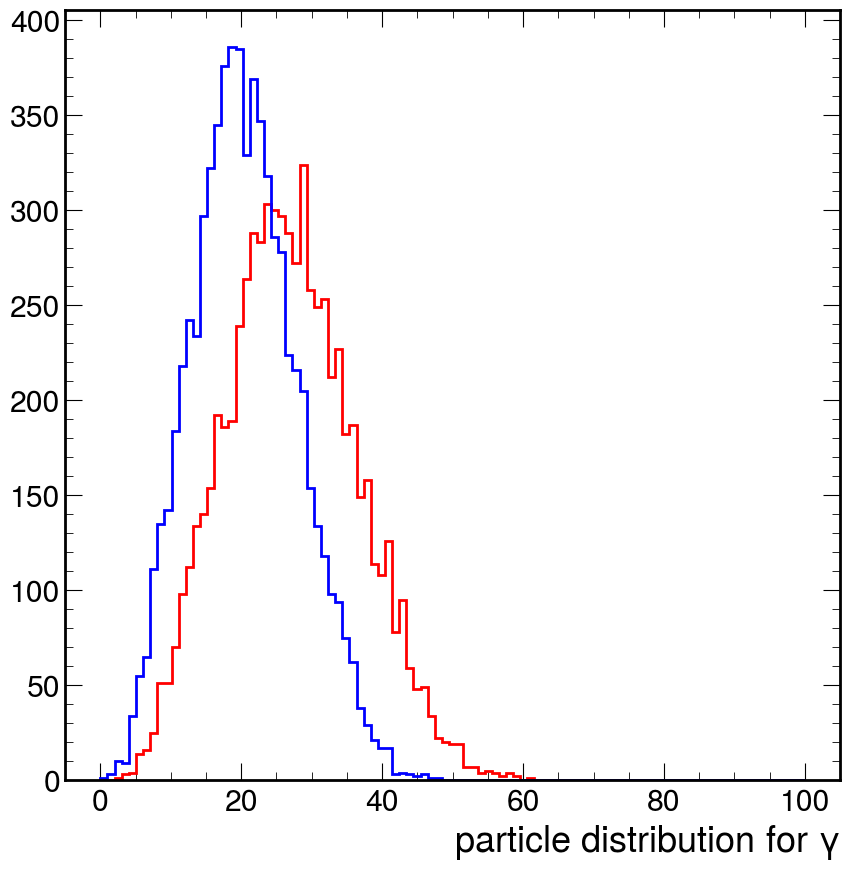

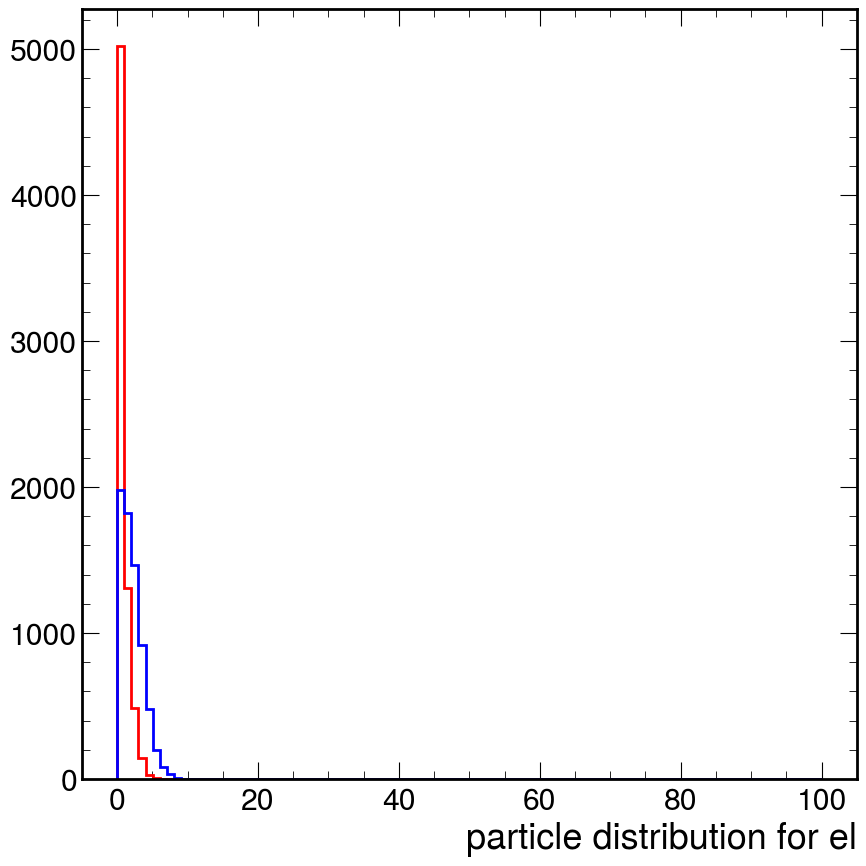

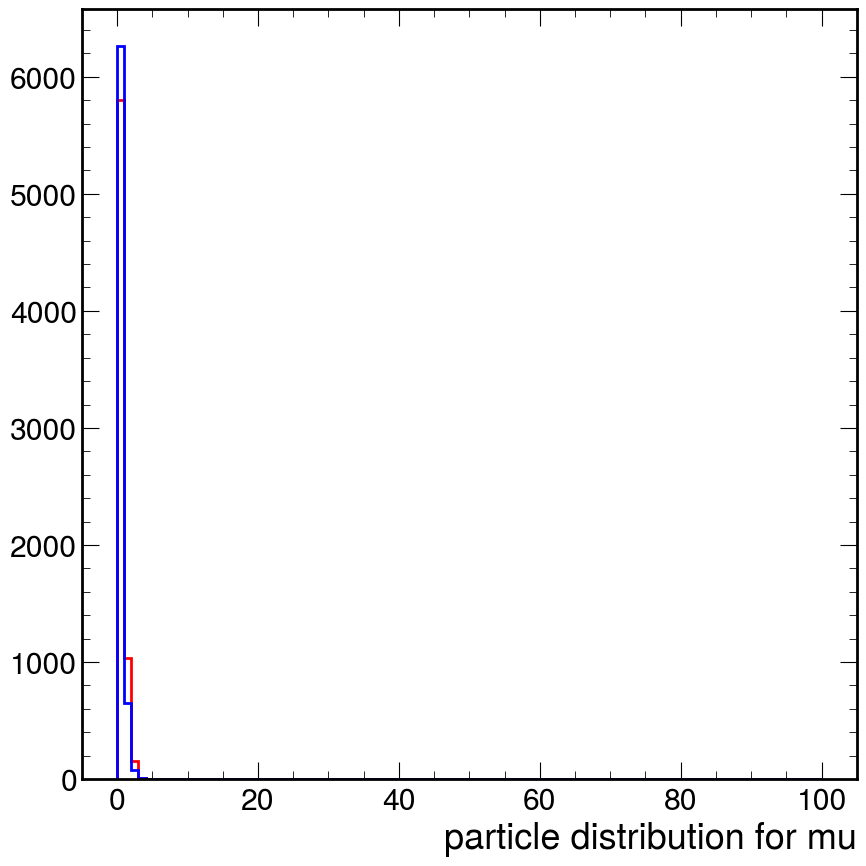

In [8]:
# plot the number of each particle one by one (multiplicity)
labels_text = {
    '0': "none",
    '7': "mu",
    '6': "el",
    '5': "$\gamma$",
    '2': "$K^0_L$",
    '1': "$\pi^\pm$",
    '321': "$K^+$",
    '2112': "n",
    '2212': "p"
}

for icls in [1,2,5,6,7]:
    mask_gen = (yvals["gen_cls_id"] == icls) #& (np.abs(yvals["gen_px"]) > 0) & (np.abs(yvals["gen_py"]) > 0) & (np.abs(yvals["gen_pz"]) > 0)
    mask_cand = (yvals["cand_cls_id"] == icls) #& (np.abs(yvals["cand_px"]) > 0) & (np.abs(yvals["cand_py"]) > 0) & (np.abs(yvals["cand_pz"]) > 0)
    ngen = np.sum(mask_gen, axis=1)
    ncand = np.sum(mask_cand, axis=1)
    #print("ngen:")
    # print("ncand:", ncand)
    fig = plt.figure()
    ax = plt.axes()
    bins = np.linspace(0,100,100)
    plt.hist(ngen, bins=bins, histtype="step", lw=2, color="r", label="generated")#, label="generated energy(GT), $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(gen_energy), np.std(gen_energy)))
    plt.hist(ncand, bins=bins, histtype="step", lw=2, color="b", label="PF")#, label="PF energy(baseline), $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(cand_energy), np.std(cand_energy)))
    plt.xlabel("particle distribution for " + labels_text[str(icls)])

[0 1 2 5 6 7]


Text(0, 1, 'number of events')

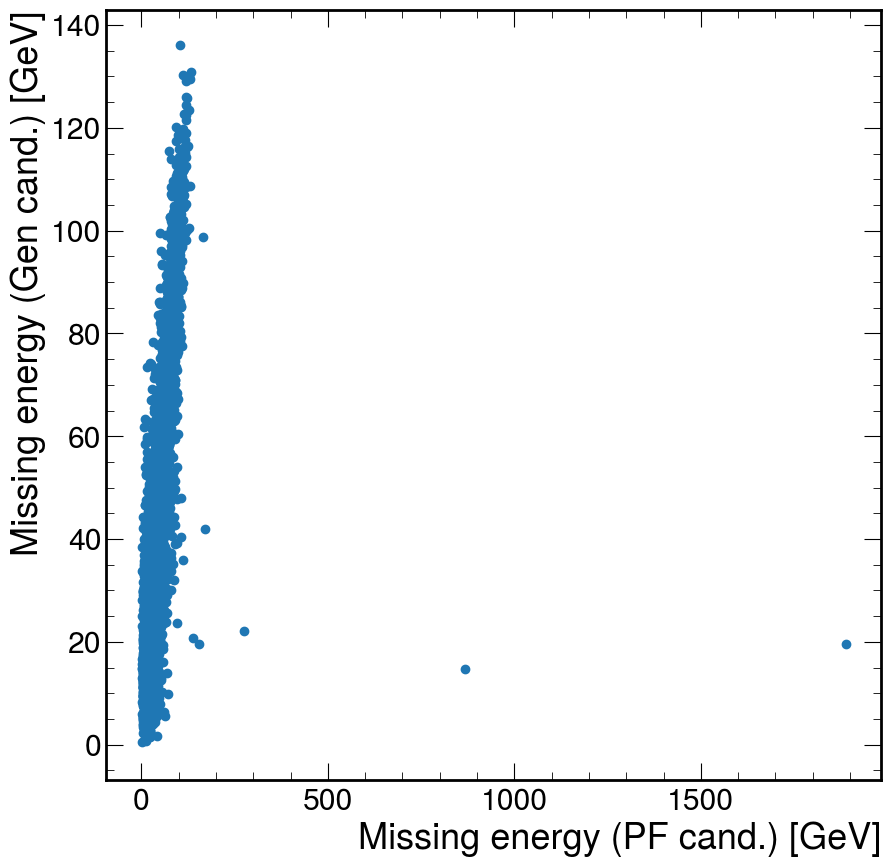

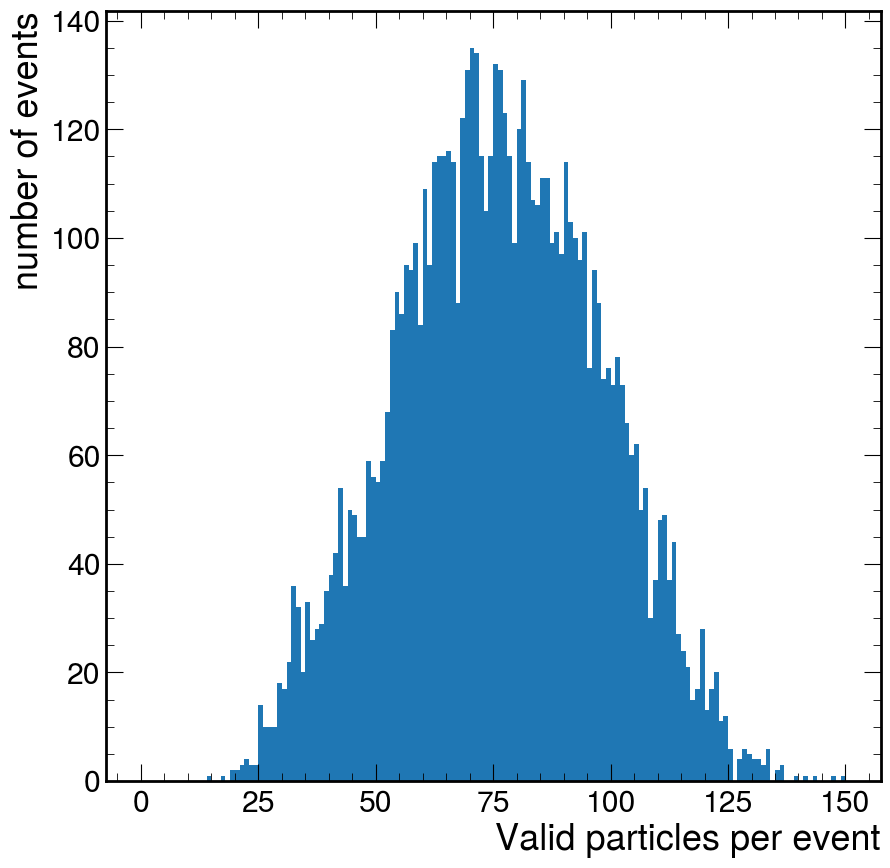

In [9]:
# plot Missing Energy
sum_px = np.sum(yvals["gen_px"], axis=1)
sum_py = np.sum(yvals["gen_py"], axis=1)
sum_pz = np.sum(yvals["gen_pz"], axis=1)
gen_me = np.sqrt(sum_px**2+sum_py**2+sum_pz**2)[:, 0]

sum_px = np.sum(yvals["cand_px"], axis=1)
sum_py = np.sum(yvals["cand_py"], axis=1)
sum_pz = np.sum(yvals["cand_pz"], axis=1)
cand_me = np.sqrt(sum_px**2+sum_py**2+sum_pz**2)[:, 0]
'''
sum_px = np.sum(yvals["pred_px"], axis=1)
sum_py = np.sum(yvals["pred_py"], axis=1)
sum_pz = np.sum(yvals["pred_pz"], axis=1)
pred_me = np.sqrt(sum_px**2+sum_py**2+sum_pz**2)[:, 0]
print(len(gen_me))
fig = plt.figure()
ax = plt.axes()
b = np.linspace(0, 150, 50)
plt.hist(cand_me, bins=b, histtype="step", lw=2, label="PF cand., $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(cand_me), np.std(cand_me)));
plt.hist(gen_me, bins=b, histtype="step", lw=2, label="Gen cand., $\mu={:.2f}$, $\sigma={:.2f}$".format(np.mean(gen_me), np.std(gen_me)));
plt.yscale("log")
cms_label(ax)
sample_label(ax)
plt.ylim(0.5, 1e2)
plt.legend(loc=(0.4, 0.7))
plt.xlabel(r"Missing energy [GeV]")
plt.ylabel("Number of events / bin")
'''
plt.figure()
plt.scatter(cand_me, gen_me)
x = np.linspace(0, 120, 1000)
plt.plot(x, x)
plt.xlabel(r"Missing energy (PF cand.) [GeV]")
plt.ylabel(r"Missing energy (Gen cand.) [GeV]")

# print(yvals["gen_cls_id"].shape)
print(np.unique(yvals["gen_cls_id"]))
# get rid of some noises
mask = (yvals["gen_cls_id"] != 0) & (np.abs(yvals["gen_px"]) > 0) & (np.abs(yvals["gen_py"]) > 0) & (np.abs(yvals["gen_pz"]) > 0)
num_gens = np.sum(mask,axis=1)

plt.figure()
plt.hist(num_gens, bins = np.linspace(0, 150, 151))
plt.xlabel(r"Valid particles per event")
plt.ylabel(r"number of events")

Text(0, 1, 'Reconstructed $\\sum E$ [GeV]')

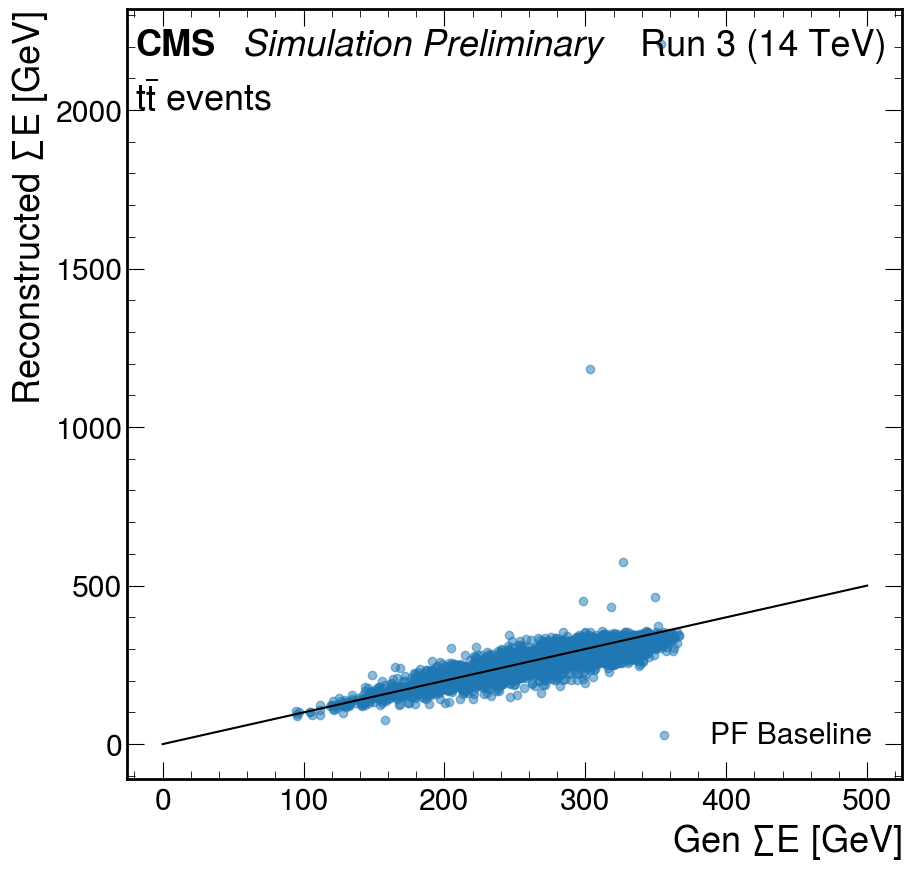

In [10]:
# event level energy distribution
fig = plt.figure()
ax = plt.axes()
# print(np.sum(yvals["gen_energt"], axis=1)[:10])
# print(np.sum(yvals["cand_energt"], axis=1)[:10])
plt.scatter(
    np.sum(yvals["gen_energt"], axis=1),
    np.sum(yvals["cand_energt"], axis=1),
    alpha=0.5,
    label="PF Baseline"
)
plt.plot([0,500],[0,500], color="black")
plt.legend(loc=4)
cms_label(ax)
sample_label(ax)
plt.xlabel("Gen $\sum E$ [GeV]")
plt.ylabel("Reconstructed $\sum E$ [GeV]")